# Las Vegas Restaurants Reviews NLP and more EDA

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import seaborn as sns

%matplotlib inline

In [2]:
# For NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import unicodedata
import string
import re

from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

np.set_printoptions(linewidth=100) 

pt = string.punctuation
sw = stopwords.words('english')
stemmer = SnowballStemmer('english')


In [3]:
from wordcloud import WordCloud, STOPWORDS 

In [37]:
# For Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Logisitc Regression
from sklearn.linear_model import LogisticRegression

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


## Data Processing

#### Import Data

In [4]:
raw_reviews = pd.read_pickle('../data/english_reviews.pkl')

In [5]:
reviews = raw_reviews.loc[raw_reviews.text.apply(lambda x : True if len(x.split(' ')) > 10 else False)]

In [6]:
reviews.reset_index(drop=True, inplace=True)

In [7]:
reviews[reviews.isna().any(axis=1)]

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,language


In [8]:
(reviews.stars.value_counts()/reviews.stars.value_counts().sum()).sort_index()

1    0.124113
2    0.084543
3    0.118845
4    0.228227
5    0.444272
Name: stars, dtype: float64

In [9]:
reviews.shape

(1527548, 10)

In [10]:
reviews.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,language
0,fnZrZlqW1Z8iWgTVDfv_MA,WUAt5-krh075Ie44np8Hew,YDkC5VVT8s9NlIZtAr8NUA,5,0,0,0,So why would I be giving a Fast Food chain loc...,2010-11-27 09:33:34,en
1,fnZrZlqW1Z8iWgTVDfv_MA,S9vIs-je49jqbhpWSQ8yHg,mxtalrN7VHVQwGjv8ln5yg,2,0,0,0,I come here bout 3x's a mo. & I just can't do ...,2016-03-19 09:03:09,en
2,fnZrZlqW1Z8iWgTVDfv_MA,i2Soid_X8XsSTyIrPOst6g,xammeA3ftpFoAN13v5Blyg,1,2,0,0,WORST experience EVER!!!!! never have i ate an...,2015-04-02 06:14:51,en
3,fnZrZlqW1Z8iWgTVDfv_MA,uDYGaAOUgo7SLuH5nUZs3w,gQhFacMGI41mfVXqw1E7bQ,4,0,0,0,Hot fresh food usually. Staff seems to turn o...,2014-08-14 23:00:34,en
4,fnZrZlqW1Z8iWgTVDfv_MA,Xg7HuBvuZHTBog1G_2Wk0w,0PXhJMztE3ijzQPjiwPERg,3,0,0,0,Beer battered cod fish seems really rubbery. I...,2015-03-23 02:10:52,en


In [11]:
# X is reviews' text and y is 5 stars or not
X = np.array(reviews.text)
y = np.array(reviews.stars.apply(lambda s: 1 if s == 5 else 0))

In [12]:
X.shape, y.shape

((1527548,), (1527548,))

In [13]:
# Baseline Accuracy/Model = 
y.sum()/len(y)

0.444272127618903

#### Split Data

In [14]:
final_X_train, final_X_test, final_y_train, final_y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [15]:
final_X_train.shape, final_y_train.shape

((1222038,), (1222038,))

In [16]:
sli = (len(final_X_train) // 2) + 1 ; sli

611020

In [17]:
X_half_1 = final_X_train[0:sli]
X_half_2 = final_X_train[sli:]

y_half_1 = final_y_train[0:sli]
y_half_2 = final_y_train[sli:]


In [18]:
y_half_1.sum(), y_half_2.sum()

(271420, 271497)

##### Small Subsets

In [21]:
X_tiny = final_X_train[501000:521000]

y_tiny = final_y_train[501000:521000]

X_tiny_t = final_X_train[524000:529000]

y_tiny_t = final_y_train[524000:529000]

y_tiny.sum(), y_tiny_t.sum()

(8807, 2236)

In [23]:
X_small = final_X_train[30000:230000]

y_small = final_y_train[30000:230000]

X_small_t = final_X_train[231000:281000]

y_small_t = final_y_train[231000:281000]

y_small.sum(), y_small_t.sum()

(88435, 22059)

## NLP

In [24]:
for i, w in enumerate(sw):
    sw[i] = w.replace("'",'')

In [25]:
sw + ['u', 'a', 'aa', 'aaa', 'im', 'ive', 'isnt'];

In [26]:
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    
    doc = re.sub(r"[^a-z ]+", '', doc)
    
    doc = word_tokenize(doc)

    #tags = pos_tag(doc, tagset='universal')
    #doc = [word for word,pos in tags if (pos == 'ADJ')]
                            #pos == 'NOUN' or pos == 'VERB' or pos == 'ADJ')]
                            # or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
            
    doc = [token for token in doc if token not in sw]

    #lemma = WordNetLemmatizer()
    #doc = [lemma.lemmatize(token) for token in doc]
    
    doc = [stemmer.stem(token) for token in doc]
    
    
    return doc

### TFIDF Vectorize X_tiny data subset

In [28]:
# Create tfidf vectorizer for tiny subset of data
tfidf_tiny = TfidfVectorizer(tokenizer=tokenizer)

In [29]:
tfidf_X_tiny = tfidf_tiny.fit_transform(X_tiny).todense();

In [30]:
columns = sorted(tfidf_tiny.vocabulary_, key=lambda k: tfidf_tiny.vocabulary_[k])
X_tiny_df = pd.DataFrame(tfidf_X_tiny, columns=columns);

In [31]:
len(X_tiny_df.columns)

37768

In [32]:
np.sum(X_tiny_df[np.array(y_tiny)==1], axis=0).sort_values(ascending=False)[:10]

great     400.342345
food      355.309416
place     329.614837
servic    270.720891
good      250.504116
love      250.232777
amaz      246.654722
best      238.763890
delici    214.065240
time      213.178613
dtype: float64

In [33]:
np.sum(X_tiny_df[np.array(y_tiny)==0], axis=0).sort_values(ascending=False)[:10]

food      414.183724
good      399.123833
order     345.034039
place     328.772749
like      279.914708
servic    275.397900
time      263.027543
get       263.005962
go        246.870398
great     232.407217
dtype: float64

In [34]:
# Transform tiny test set
tfidf_X_tiny_t = tfidf_tiny.transform(X_tiny_t).todense()

### TFIDF Vectorize X_small data subset

In [72]:
# Create tfidf vectorizer for small subset of data
tfidf_small = TfidfVectorizer(tokenizer=tokenizer, vocabulary=mVOCAB)

In [73]:
tfidf_X_small = tfidf_small.fit_transform(X_small).todense();

In [74]:
columns = sorted(tfidf_small.vocabulary_, key=lambda k: tfidf_small.vocabulary_[k])
X_small_df = pd.DataFrame(tfidf_X_small, columns=columns);

In [ ]:
#len(X_small_df.columns)

In [ ]:
#X_small_df.columns[150:200]

In [ ]:
#np.sum(X_small_df[np.array(y_small)==1], axis=0).sort_values(ascending=False)[:10]

In [ ]:
#np.sum(X_small_df[np.array(y_small)==0], axis=0).sort_values(ascending=False)[:10]

In [75]:
# Transform small test set
tfidf_X_small_t = tfidf_small.transform(X_small_t).todense()

# Models

### Models with Tiny Dataset

#### Logistic Regression

In [38]:
tiny_log = LogisticRegression()

In [39]:
tiny_log.fit(tfidf_X_tiny, y_tiny)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# training scores
accuracy_score(y_tiny, tiny_log.predict(tfidf_X_tiny)), f1_score(y_tiny, tiny_log.predict(tfidf_X_tiny))

(0.86415, 0.844074605451937)

In [44]:
y_tiny_prob = tiny_log.predict_proba(tfidf_X_tiny_t)[:,1]
y_tiny_hat = tiny_log.predict(tfidf_X_tiny_t)

In [45]:
# test scores
accuracy_score(y_tiny_t, y_tiny_hat), f1_score(y_tiny_t, y_tiny_hat)

(0.8116, 0.7862006354970495)

#### Random Forest

In [46]:
# best random forest parameters found
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=50, max_features='sqrt')
rfc.fit(tfidf_X_tiny, y_tiny)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
# training scores
accuracy_score(y_tiny, rfc.predict(tfidf_X_tiny)), f1_score(y_tiny, rfc.predict(tfidf_X_tiny))

(0.9684, 0.9645541222658441)

In [48]:
rfc_y_tiny_prob = rfc.predict_proba(tfidf_X_tiny_t)
rfc_y_tiny_hat = rfc.predict(tfidf_X_tiny_t)

In [49]:
# test scores
accuracy_score(y_tiny_t, y_tiny_hat), f1_score(y_tiny_t, y_tiny_hat)

(0.8116, 0.7862006354970495)

In [51]:
importances = rfc.feature_importances_; len(importances)

37768

In [52]:
indices = importances.argsort()[::-1]
indices;

In [64]:
# top 500 features in the model
X_tiny_df.columns[indices].tolist()[:10]

['amaz',
 'best',
 'love',
 'great',
 'delici',
 'recommend',
 'would',
 'awesom',
 'like',
 'definit']

In [59]:
# 1000 vocabulary
sVOCAB = ['amaz',
 'best',
 'love',
 'great',
 'delici',
 'recommend',
 'would',
 'awesom',
 'like',
 'definit',
 'vega',
 'pretti',
 'perfect',
 'ok',
 'order',
 'bad',
 'get',
 'good',
 'place',
 'servic',
 'thank',
 'terribl',
 'favorit',
 'worst',
 'alway',
 'excel',
 'star',
 'slow',
 'food',
 'bland',
 'decent',
 'friend',
 'everyth',
 'back',
 'noth',
 'howev',
 'staff',
 'horribl',
 'better',
 'pay',
 'fresh',
 'minut',
 'seem',
 'everi',
 'super',
 'dri',
 'littl',
 'go',
 'give',
 'come',
 'wait',
 'tri',
 'one',
 'anoth',
 'told',
 'could',
 'time',
 'expect',
 'charg',
 'mayb',
 'overal',
 'cant',
 'also',
 'rude',
 'got',
 'said',
 'ask',
 'use',
 'high',
 'room',
 'bit',
 'realli',
 'okay',
 'tabl',
 'ive',
 'much',
 'nice',
 'look',
 'wonder',
 'came',
 'ever',
 'tast',
 'town',
 'absolut',
 'still',
 'make',
 'suck',
 'want',
 'drink',
 'spot',
 'well',
 'restaur',
 'price',
 'las',
 'must',
 'lack',
 'disappoint',
 'though',
 'rather',
 'averag',
 'fantast',
 'us',
 'never',
 'even',
 'guess',
 'mediocr',
 'took',
 'say',
 'think',
 'poor',
 'made',
 'cold',
 'unfortun',
 'locat',
 'overpr',
 'enjoy',
 'way',
 'manag',
 'went',
 'experi',
 'menu',
 'famili',
 'money',
 'chicken',
 'take',
 'need',
 'visit',
 'help',
 'im',
 'first',
 'hour',
 'peopl',
 'fri',
 'aw',
 'eat',
 'sure',
 'lot',
 'thing',
 'quit',
 'flavor',
 'attent',
 'worth',
 'that',
 'right',
 'hotel',
 'welcom',
 'outstand',
 'small',
 'top',
 'new',
 'incred',
 'around',
 'two',
 'everyon',
 'chef',
 'paid',
 'salad',
 'stay',
 'end',
 'dish',
 'custom',
 'meal',
 'next',
 'busi',
 'night',
 'dinner',
 'portion',
 'side',
 'lunch',
 'find',
 'server',
 'someon',
 'strip',
 'atmospher',
 'expens',
 'id',
 'call',
 'die',
 'bar',
 'quick',
 'cost',
 'final',
 'actual',
 'someth',
 'walk',
 'stop',
 'sweet',
 'happi',
 'gem',
 'reason',
 'check',
 'sit',
 'line',
 'given',
 'long',
 'els',
 'beauti',
 'thought',
 'bill',
 'know',
 'cook',
 'day',
 'differ',
 'soon',
 'buffet',
 'mani',
 'serv',
 'suppos',
 'probabl',
 'anyth',
 'pizza',
 'fast',
 'wors',
 'sinc',
 'sushi',
 'left',
 'review',
 'instead',
 'hard',
 'seat',
 'tasti',
 'meat',
 'dessert',
 'breakfast',
 'last',
 'fine',
 'open',
 'min',
 'burger',
 'see',
 'half',
 'sauc',
 'sandwich',
 'wast',
 'feel',
 'special',
 'away',
 'far',
 'apolog',
 'glad',
 'huge',
 'felt',
 'chees',
 'pm',
 'let',
 'waitress',
 'work',
 'rice',
 'rate',
 'elsewher',
 'year',
 'least',
 'hope',
 'home',
 'plate',
 'clean',
 'hot',
 'wrong',
 'trip',
 'full',
 'piec',
 'live',
 'coupl',
 'loud',
 'part',
 'enough',
 'extra',
 'size',
 'soup',
 'water',
 'spici',
 'alright',
 'oh',
 'keep',
 'big',
 'option',
 'disgust',
 'bread',
 'put',
 'husband',
 'yummi',
 'notch',
 'casino',
 'watch',
 'hand',
 'either',
 'owner',
 'potato',
 'dine',
 'decid',
 'vegan',
 'omg',
 'return',
 'fun',
 'gave',
 'cheap',
 'hous',
 'greet',
 'beef',
 'guy',
 'usual',
 'outsid',
 'steak',
 'offer',
 'point',
 'close',
 'coffe',
 'waiter',
 'shrimp',
 'item',
 'issu',
 'start',
 'roll',
 'problem',
 'qualiti',
 'sad',
 'wish',
 'week',
 'area',
 'leav',
 'show',
 'ice',
 'free',
 'almost',
 'ate',
 'person',
 'fish',
 'receiv',
 'kind',
 'local',
 'front',
 'heaven',
 'fill',
 'select',
 'tender',
 'bite',
 'turn',
 'share',
 'insid',
 'empti',
 'old',
 'phenomen',
 'flag',
 'crab',
 'chang',
 'egg',
 'ambianc',
 'thai',
 'appet',
 'late',
 'drive',
 'ill',
 'tea',
 'present',
 'arriv',
 'life',
 'choic',
 'deal',
 'otherwis',
 'park',
 'mouth',
 'pricey',
 'salti',
 'bomb',
 'yelp',
 'music',
 'cours',
 'wow',
 'regular',
 'kid',
 'decor',
 'less',
 'brought',
 'surpris',
 'cake',
 'larg',
 'pleas',
 'care',
 'dirti',
 'believ',
 'authent',
 'complain',
 'happen',
 'found',
 'limit',
 'impress',
 'real',
 'solid',
 'parti',
 'three',
 'cut',
 'may',
 'sat',
 'attitud',
 'tell',
 'fan',
 'card',
 'chip',
 'varieti',
 'floor',
 'garlic',
 'flavorless',
 'onion',
 'fair',
 'basic',
 'group',
 'tomato',
 'anyon',
 'season',
 'cream',
 'without',
 'style',
 'understand',
 'pork',
 'rush',
 'easi',
 'reserv',
 'crispi',
 'gross',
 'clear',
 'truli',
 'cool',
 'bbq',
 'green',
 'spend',
 'hungri',
 'frozen',
 'except',
 'fact',
 'veggi',
 'bring',
 'grill',
 'accommod',
 'becom',
 'move',
 'pick',
 'forev',
 'crave',
 'wife',
 'later',
 'especi',
 'done',
 'amount',
 'bother',
 'stand',
 'knew',
 'bartend',
 'although',
 'hidden',
 'plus',
 'hit',
 'total',
 'stale',
 'sever',
 'cute',
 'rest',
 'chocol',
 'second',
 'name',
 'theyr',
 'toast',
 'short',
 'birthday',
 'uniqu',
 'main',
 'mean',
 'includ',
 'sorri',
 'near',
 'girl',
 'red',
 'forward',
 'wine',
 'seafood',
 'salsa',
 'beer',
 'corn',
 'anywher',
 'prepar',
 'set',
 'club',
 'saw',
 'twice',
 'forgot',
 'suggest',
 'combo',
 'chines',
 'rib',
 'entre',
 'plenti',
 'possibl',
 'extrem',
 'mention',
 'noodl',
 'date',
 'consid',
 'taco',
 'juici',
 'month',
 'add',
 'superb',
 'door',
 'crowd',
 'ramen',
 'excit',
 'anyway',
 'eaten',
 'standard',
 'employe',
 'complet',
 'warm',
 'honest',
 'mix',
 'phone',
 'mexican',
 'pack',
 'whole',
 'bacon',
 'hype',
 'might',
 'avoid',
 'shop',
 'pasta',
 'celebr',
 'view',
 'complaint',
 'tip',
 'refil',
 'miss',
 'caus',
 'desk',
 'run',
 'soggi',
 'knowledg',
 'wing',
 'tasteless',
 'overcook',
 'bean',
 'cocktail',
 'acknowledg',
 'stuff',
 'job',
 'bag',
 'banana',
 'tradit',
 'bare',
 'dress',
 'butter',
 'plain',
 'smile',
 'salt',
 'yes',
 'due',
 'notic',
 'serious',
 'appreci',
 'today',
 'smell',
 'bowl',
 'somewher',
 'kept',
 'oyster',
 'kitchen',
 'ingredi',
 'correct',
 'five',
 'along',
 'abl',
 'compar',
 'gone',
 'rock',
 'meh',
 'mind',
 'rare',
 'sign',
 'kinda',
 'certain',
 'treat',
 'stuf',
 'medium',
 'save',
 'ago',
 'lobster',
 'homemad',
 'often',
 'there',
 'roast',
 'diner',
 'poke',
 'fix',
 'greasi',
 'curri',
 'other',
 'pair',
 'tini',
 'longer',
 'finish',
 'alreadi',
 'street',
 'pass',
 'pancak',
 'weekend',
 'sunday',
 'game',
 'smoke',
 'allow',
 'type',
 'store',
 'rememb',
 'sometim',
 'rich',
 'level',
 'fabul',
 'lol',
 'french',
 'slight',
 'black',
 'heard',
 'japanes',
 'readi',
 'simpl',
 'generous',
 'slice',
 'window',
 'across',
 'soft',
 'mall',
 'list',
 'saturday',
 'four',
 'spice',
 'pictur',
 'sausag',
 'prime',
 'ignor',
 'salmon',
 'state',
 'world',
 'counter',
 'vibe',
 'whenev',
 'burrito',
 'beyond',
 'burnt',
 'yet',
 'normal',
 'lover',
 'entir',
 'base',
 'mac',
 'consist',
 'per',
 'liter',
 'ad',
 'pleasant',
 'afford',
 'ridicul',
 'exact',
 'tuna',
 'joint',
 'margarita',
 'daughter',
 'broth',
 'buck',
 'nois',
 'choos',
 'bake',
 'crazi',
 'fluffi',
 'nacho',
 'ladi',
 'hostess',
 'la',
 'light',
 'exceed',
 'head',
 'pull',
 'yum',
 'n',
 'talk',
 'filet',
 'brown',
 'provid',
 'waffl',
 'cup',
 'profession',
 'creami',
 'conveni',
 'addit',
 'prefer',
 'upon',
 'ayc',
 'california',
 'sea',
 'singl',
 'annoy',
 'negat',
 'mushroom',
 'boyfriend',
 'earli',
 'morn',
 'cafe',
 'comfort',
 'prompt',
 'creativ',
 'delish',
 'particular',
 'bottl',
 'belli',
 'bathroom',
 'weve',
 'healthi',
 'yell',
 'italian',
 'word',
 'beat',
 'hubbi',
 'hate',
 'melt',
 'korean',
 'mash',
 'polit',
 'shake',
 'within',
 'fountain',
 'over',
 'behind',
 'refresh',
 'pepper',
 'confus',
 'weird',
 'import',
 'casual',
 'speak',
 'mom',
 'valu',
 'indian',
 'interest',
 'modern',
 'pie',
 'cashier',
 'citi',
 'sum',
 'truffl',
 'impecc',
 'space',
 'easili',
 'brunch',
 'satisfi',
 'man',
 'bellagio',
 'pho',
 'write',
 'hear',
 'question',
 'moment',
 'cover',
 'mess',
 'patio',
 'doubl',
 'golden',
 'savori',
 'cuisin',
 'alon',
 'deliv',
 'mango',
 'ruin',
 'figur',
 'combin',
 'dip',
 'desert',
 'section',
 'ambienc',
 'obvious',
 'taken',
 'guest',
 'avail',
 'team',
 'caesar',
 'recent',
 'steakhous',
 'cooki',
 'chill',
 'environ',
 'face',
 'lemon',
 'hes',
 'lost',
 'glass',
 'starv',
 'play',
 'book',
 'station',
 'past',
 'white',
 'sound',
 'sick',
 'win',
 'lettuc',
 'fruit',
 'touch',
 'relat',
 'wynn',
 'soooo',
 'terrif',
 'togeth',
 'regret',
 'chop',
 'simpli',
 'w',
 'moist',
 'tough',
 'crust',
 'patient',
 'number',
 'smaller',
 'ton',
 'joke',
 'establish',
 'boy',
 'forget',
 'hash',
 'blue',
 'discount',
 'immedi',
 'answer',
 'idea',
 'middl',
 'pud',
 'brew',
 'begin',
 'damn',
 'crap',
 'york',
 'request',
 'contact',
 'low',
 'effici',
 'learn',
 'finger',
 'seen',
 'sprout',
 'popular',
 'cozi',
 'case',
 'pastri',
 'tv',
 'delight',
 'avocado',
 'eater',
 'quiet',
 'sent',
 'search',
 'gon',
 'chanc',
 'spinach',
 'major',
 'bun',
 'anniversari',
 'chewi',
 'scallop',
 'dog',
 'shut',
 'deep',
 'duck',
 'nasti',
 'hang',
 'depend',
 'vegetarian',
 'mistak',
 'booth',
 'wrap',
 'plan',
 'whatev',
 'ring',
 'leg',
 'detail',
 'realiz',
 'soda',
 'purchas',
 'southern',
 'frequent',
 'tom',
 'origin',
 'deserv',
 'benedict',
 'relax',
 'penni',
 'cheaper',
 'tempura',
 'crisp',
 'tower',
 'pink',
 'girlfriend',
 'self',
 'mignon',
 'lamb',
 'shot',
 'chain',
 'goe',
 'split',
 'kick',
 'veget',
 'general',
 'read',
 'heart',
 'picki',
 'undercook',
 'lucki',
 'pop',
 'unless',
 'previous',
 'bed',
 'typic',
 'sashimi',
 'updat',
 'wouldv',
 'follow',
 'textur',
 'nearbi',
 'luckili',
 'parmesan',
 'loung',
 'strawberri',
 'signatur',
 'brule',
 'def',
 'tail',
 'odd',
 'friday',
 'convers',
 'etc',
 'famous',
 'inform',
 'genuin',
 'mile',
 'blah',
 'ny',
 'most',
 'multipl',
 'ran',
 'u',
 'step',
 'interior',
 'honey',
 'batter',
 'own',
 'hawaiian',
 'complimentari',
 'grab',
 'sticki',
 'market',
 'meet',
 'drop',
 'chorizo',
 'similar',
 'outdoor',
 'deliveri',
 'wall',
 'sour',
 'biscuit',
 'spent',
 'higher',
 'stick',
 'st',
 'closer',
 'machin',
 'fanci',
 'platter',
 'build',
 'awkward',
 'american',
 'mine',
 'brisket',
 'throw',
 'starter',
 'eye',
 'pepperoni',
 'note',
 'aria',
 'ahead',
 'cowork',
 'buy',
 'calamari',
 'pan',
 'gotten',
 'bought',
 'hell',
 'app',
 'juic',
 'accept',
 'travel',
 'pool',
 'sooo',
 'son',
 'skip',
 'vietnames',
 'snack',
 'lv',
 'milk']

In [65]:
mVOCAB = X_tiny_df.columns[indices].tolist()[:5000]

In [63]:
bigVOCAB = X_tiny_df.columns[indices].tolist()[:10000]

#### Gradient Boosting Classifier

In [253]:
tiny_gbc = GradientBoostingClassifier(learning_rate=0.1,
                                  n_estimators=50,
                                  max_depth=5,
                                max_features='sqrt')
tiny_gbc.fit(tfidf_X_tiny, y_tiny)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [67]:
accuracy_score(y_tiny, tiny_gbc.predict(tfidf_X_tiny)), f1_score(y_tiny, tiny_gbc.predict(tfidf_X_tiny))

(0.8101, 0.7423337856173677)

In [70]:
tiny_gbc_y_hat = tiny_gbc.predict(tfidf_X_tiny_t)
tiny_gbc_y_prob = tiny_gbc.predict_proba(tfidf_X_tiny_t)[:,1]

In [71]:
accuracy_score(y_tiny_t, tiny_gbc_y_hat), f1_score(y_tiny_t, tiny_gbc_y_hat)

(0.7348, 0.6256352343308865)

#### Naive Bayes Model

In [66]:
tiny_nbc = MultinomialNB().fit(tfidf_X_tiny, y_tiny)

In [67]:
accuracy_score(y_tiny, tiny_nbc.predict(tfidf_X_tiny)), f1_score(y_tiny, tiny_nbc.predict(tfidf_X_tiny))

(0.8101, 0.7423337856173677)

In [70]:
tiny_nbc_y_hat = tiny_nbc.predict(tfidf_X_tiny_t)
tiny_nbc_y_prob = tiny_nbc.predict_proba(tfidf_X_tiny_t)[:,1]

In [71]:
accuracy_score(y_tiny_t, tiny_nbc_y_hat), f1_score(y_tiny_t, tiny_nbc_y_hat)

(0.7348, 0.6256352343308865)

### Models with Small Dataset

#### Logistic Regression

In [76]:
small_log = LogisticRegression()

In [77]:
small_log.fit(tfidf_X_small, y_small)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
# training scores
accuracy_score(y_small, small_log.predict(tfidf_X_small)), f1_score(y_small, small_log.predict(tfidf_X_small))

(0.834095, 0.8126753645606922)

In [79]:
y_small_prob = small_log.predict_proba(tfidf_X_small_t)
y_small_hat = small_log.predict(tfidf_X_small_t)

In [80]:
# test scores
accuracy_score(y_small_t, y_small_hat), f1_score(y_small_t, y_small_hat)

(0.82802, 0.8053864433631323)

#### Random Forest

In [86]:
# best random forest parameters found
small_rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=50, max_features='sqrt')
small_rfc.fit(tfidf_X_small, y_small)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
# training scores
accuracy_score(y_small, small_rfc.predict(tfidf_X_small)), f1_score(y_small, small_rfc.predict(tfidf_X_small))

(0.94484, 0.9381246704880704)

In [92]:
small_rfc_y_prob = small_rfc.predict_proba(tfidf_X_small_t)
small_rfc_y_hat = small_rfc.predict(tfidf_X_small_t)

In [94]:
# test scores
accuracy_score(y_small_t, small_rfc_y_hat), f1_score(y_small_t, small_rfc_y_hat)

(0.7953, 0.7596458680694174)

#### Gradient Boosting Classifier

In [88]:
small_gbc = GradientBoostingClassifier(learning_rate=0.1,
                                  n_estimators=50,
                                  max_depth=5,
                                max_features='sqrt')
small_gbc.fit(tfidf_X_small, y_small)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [89]:
accuracy_score(y_small, small_gbc.predict(tfidf_X_small)), f1_score(y_small, small_gbc.predict(tfidf_X_small))

(0.776795, 0.7277606005720314)

In [90]:
small_gbc_y_hat = small_gbc.predict(tfidf_X_small_t)
small_gbc_y_prob = small_gbc.predict_proba(tfidf_X_small_t)[:,1]

In [91]:
accuracy_score(y_small_t, small_gbc_y_hat), f1_score(y_small_t, small_gbc_y_hat)

(0.77714, 0.7282393971172842)

#### AdaBoost Classifier

In [95]:
abc = AdaBoostClassifier(learning_rate=0.2, n_estimators=50)
abc.fit(tfidf_X_small, y_small)

KeyboardInterrupt: 

In [ ]:
accuracy_score(y_small, abc.predict(tfidf_X_small)), f1_score(y_small, abc.predict(tfidf_X_small))

In [ ]:
small_abc_y_hat = abc.predict(tfidf_X_small_t)
small_abc_y_prob = abc.predict_proba(tfidf_X_small_t)[:,1]

In [ ]:
accuracy_score(y_small_t, small_abc_y_hat), f1_score(y_small_t, small_abc_y_hat)

#### Naive Bayes Model

In [81]:
small_nbc = MultinomialNB().fit(tfidf_X_small, y_small)

In [82]:
accuracy_score(y_small, small_nbc.predict(tfidf_X_small)), f1_score(y_small, small_nbc.predict(tfidf_X_small))

(0.8039, 0.7750553471672575)

In [83]:
small_nbc_y_hat = small_nbc.predict(tfidf_X_small_t)
small_nbc_y_prob = small_nbc.predict_proba(tfidf_X_small_t)[:,1]

In [85]:
accuracy_score(y_small_t, small_nbc_y_hat), f1_score(y_small_t, small_nbc_y_hat)

(0.80134, 0.7713555693667564)

### ROC Curve

In [ ]:
# y_prob = probabilities and y_test = labels

def ROC_curve(probabilities, labels):
    
    #Sort instances by their prediction strength (the probabilities)
    thresholds = np.sort(probabilities)
    
    TPRs = []
    FPRs = []
    
    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases
    
    #For every instance in increasing order of probability:
    for idx, threshold in enumerate(thresholds):
        
        #Set everything above the threshold to the positive class
        predicted_positive = probabilities >= threshold
        
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        
        #Calculate the True Positive Rate (aka sensitivity or recall)
        #True positives divided by positive cases
        TPR = true_positives / num_positive_cases
        TPRs.append(TPR)
        
        #Calculate the False Positive Rate (1 - specificity)
        FPR = false_positives / num_negative_cases
        FPRs.append(FPR)
    
    #Return three lists: TPRs, FPRs, thresholds
    return TPRs, FPRs, thresholds

In [ ]:
# y_small_prob, small_rfc_y_prob, small_gbc_y_prob, small_abc_y_prob, small_nbc_y_prob

TPRs, FPRs, thresholds = ROC_curve(y_small_prob, y_small_t)

fig, ax = plt.subplots()
ax.plot(FPRs, TPRs)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('ROC Curve', fontsize=20)
#plt.savefig('roc_curve.png')

## Additional Exploratory Data Analysis

In [35]:
# Word Cloud for Reviews

comment_words = '' 
#stopwords = set(STOPWORDS) 
# stopwords = sw
  
# iterate through the csv file 
for val in X_small: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = tokenizer(val) 
      
    comment_words += " ".join(tokens)+" "

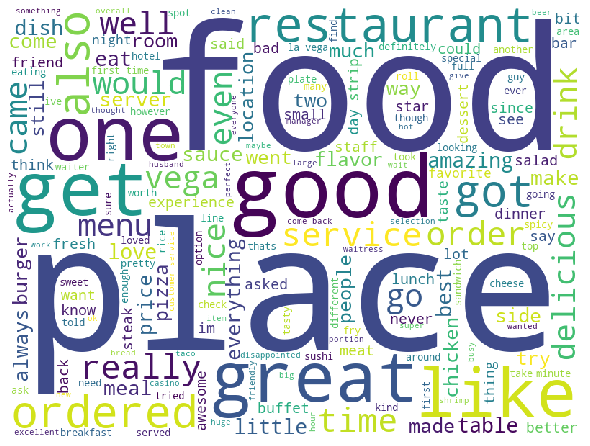

In [36]:
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                stopwords = sw, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()